In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2
print('TF version:', tf.__version__ , '\nGPU available:', tf.test.is_gpu_available())

TF version: 2.0.0 
GPU available: False


# Read Data
- all datasets are datetime sorted

In [2]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../' # Paperspace

## Amazon Fashion 

In [11]:
# data_path = 'datasets/' # Paperspace
data_path = 'Data/Amazon/'
file_name = 'Amazon_01_users'
# file_name = 'am_like_ml_01'

## MovieLens 

In [12]:
# data_path = 'datasets/' # Paperspace
# data_path = 'Data/ML/'
# file_name = 'ML_05_users'
# file_name = 'ML_01_users'

In [13]:
df = pd.read_pickle(path + data_path + file_name)
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes

df.head()

,user,item,datetime,rating,item_id,user_id
4983863,A39ZLL8ILVT2J8,B00FXSELCM,2014-03-24,3.0,104506,73226
7294092,A39ZLL8ILVT2J8,B00VDPQ884,2016-06-29,5.0,175639,73226
4809981,A39ZLL8ILVT2J8,B00EWC0W3W,2016-08-14,5.0,99224,73226
9337932,A39ZLL8ILVT2J8,B01EZKMD64,2016-10-03,5.0,238824,73226
8832820,A39ZLL8ILVT2J8,B01ABS4646,2016-12-22,5.0,222085,73226


# Data Prep

## Init

In [14]:
total_items = len(df.item_id.unique())

In [ ]:
res_ext = file_name[:2]
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models')

### New Model?

In [14]:
new_model_id = str(int(all_models.model_id.max()[0]) + 1) + '_' + res_ext

In [15]:
res_ext = file_name[:2]
new_model_id = str(0) + '_' + res_ext

In [16]:
params = {
'model_id':new_model_id,
'train_time':0,
'epochs':0,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.6,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median

'val_perc':0.1,          # Percentage of users from df in val and test set
'test_perc':0.1, 
'n_items_val':0,        # Number of last (chronologically) items in val and test set
'n_items_test':1,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [17]:
BATCH_SIZE = params['BATCH_SIZE']
learning_rate = params['learning_rate']
delta = params['delta']
max_seq_len = params['max_seq_len']

val_perc = params['val_perc']
test_perc = params['test_perc']
n_items_val = params['n_items_val']
n_items_test = params['n_items_test']

pad_value = params['pad_value']
shift_targets_by = params['shift_targets_by'] 

## Train Test Split

In [18]:
from Data_prep import train_val_test_split

# Train Test Val Split
data_split = train_val_test_split(df, val_perc, test_perc, n_items_val, n_items_test, seqs=True)

train_set, val_set, val_left_out_items, test_set, test_left_out_items = data_split

## Create Datasets

In [19]:
from Data_prep import create_seq_batch_dataset
 
#Train Set
train_dataset = create_seq_batch_dataset(df=train_set, 
                                         shift=shift_targets_by, 
                                         max_seq_len=max_seq_len, 
                                         pad_value=pad_value, 
                                         batch_size=BATCH_SIZE, 
                                         stats=False,
                                         drop_remainder=True)

#Val Set
val_dataset = create_seq_batch_dataset(df=val_set, 
                                       shift=shift_targets_by, 
                                       max_seq_len=max_seq_len, 
                                       pad_value=pad_value, 
                                       batch_size=BATCH_SIZE, 
                                       stats=False,
                                       drop_remainder=True)

# #Test Set
# test_dataset = create_seq_batch_dataset(df=test_set, 
#                                        shift=shift_targets_by, 
#                                        max_seq_len=max_seq_len, 
#                                        pad_value=pad_value, 
#                                        batch_size=BATCH_SIZE, 
#                                        stats=False,
#                                        drop_remainder=True)

---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks
- paper: https://arxiv.org/pdf/1608.07400.pdf
- code: https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Build Model

In [20]:
embedding_dim = 100
rnn_units = 20

In [21]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items, # +1 because padding is total_items+1
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = BATCH_SIZE)

## Add Custom Metric=Recall and Loss=Diversity Bias Loss

In [22]:
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias

In [23]:
diversity_bias = create_diversity_bias(train_set, total_items, delta)

In [24]:
optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)
loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
metrics=[recall_metric(total_items=total_items)]

model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=metrics)

## Summmary

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 100)           24746600  
_________________________________________________________________
masking (Masking)            (32, None, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (32, None, 20)            9680      
_________________________________________________________________
dense (Dense)                (32, None, 247465)        5196765   
Total params: 29,953,045
Trainable params: 29,953,045
Non-trainable params: 0
_________________________________________________________________


---
# Train Model

## Configure Callbacks

In [51]:
ext = '_' + file_name[:2] #ML or Am
# directory = './ckpts/ckpts' 
directory = '../ckpts/ckpts'

# Directory where the checkpoints will be saved
checkpoint_dir = directory + '_' + str(params['model_id'])

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [52]:
from Helpers import TimingCallback

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,    
                                                         monitor = 'val_recall',    
                                                         mode = 'max',    
                                                         save_best_only = True,
                                                         save_weights_only = True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_recall',
                                                           min_delta = 0.0001,
                                                           mode = 'max',
                                                           patience = 15)
    

timing_callback = TimingCallback()

callbacks = [checkpoint_callback, early_stopping_callback, timing_callback]

## Fit Model

In [53]:
epochs = 2
print('#Batches:', tf.data.experimental.cardinality(train_dataset).numpy())
print('Batch size:', BATCH_SIZE)

#Batches: 406
Batch size: 32


In [55]:
print('Fitting LSTM with max sequence length:', str(max_seq_len))
history = model.fit(x = train_dataset, 
                    validation_data=val_dataset, 
                    epochs=epochs,
                    callbacks=callbacks)

Fitting LSTM with max sequence length: 30
Epoch 1/2
     35/Unknown - 4s 117ms/step - loss: 1.7891 - recall: 0.0000e+00WARNING:tensorflow:Can save best model only with val_recall available, skipping.
     35/Unknown - 4s 117ms/step - loss: 1.7891 - recall: 0.0000e+00

KeyboardInterrupt: 

## Plot Training Loss, Metrics

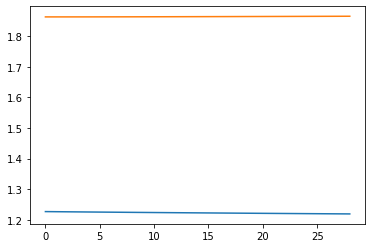

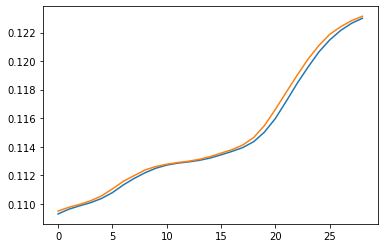

In [26]:
results = history.history
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.show()
plt.plot(results['recall'])
plt.plot(results['val_recall'])
plt.show()

---
## Continue training from checkpoint

### Load Weights

In [20]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items,
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = BATCH_SIZE)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

### Compile

In [21]:
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias
diversity_bias = create_diversity_bias(train_set, total_items, delta)

optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)
loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
metrics=[recall_metric(total_items=total_items)]

model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=metrics)

In [22]:
initial_epoch = 71
total_epochs = 100

### Continue Training

In [23]:
history = model.fit(x = train_dataset, 
                    validation_data=val_dataset, 
                    epochs=total_epochs, 
                    callbacks=callbacks, 
                    initial_epoch=initial_epoch)

Epoch 72/100
3034/3034 [==============================] - 542s 179ms/step - loss: 1.2271 - recall: 0.1093 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 73/100
3034/3034 [==============================] - 534s 176ms/step - loss: 1.2269 - recall: 0.1096 - val_loss: 1.8627 - val_recall: 0.1098
Epoch 74/100
3034/3034 [==============================] - 537s 177ms/step - loss: 1.2265 - recall: 0.1099 - val_loss: 1.8627 - val_recall: 0.1100
Epoch 75/100
3034/3034 [==============================] - 532s 175ms/step - loss: 1.2262 - recall: 0.1101 - val_loss: 1.8627 - val_recall: 0.1102
Epoch 76/100
3034/3034 [==============================] - 534s 176ms/step - loss: 1.2259 - recall: 0.1104 - val_loss: 1.8628 - val_recall: 0.1105
Epoch 77/100
3034/3034 [==============================] - 536s 177ms/step - loss: 1.2256 - recall: 0.1108 - val_loss: 1.8628 - val_recall: 0.1110
Epoch 78/100
3034/3034 [==============================] - 538s 177ms/step - loss: 1.2253 - recall: 0.1113 - val_loss

---
# Predict Sequences

## Restore Latest Checkpoints

In [31]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items, 
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = 1,
                         return_sequences=False)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

print('Latest checkpoint from:', tf.train.latest_checkpoint(checkpoint_dir))

Latest checkpoint from: ../ckpts/ckpts_0_Am/ckpt


## Predict
- CREATE MULTIPROCESSING FOR PREDICTIONS

In [200]:
from Data_prep import leave_users_out
def split_df_by_users(df, left_out_items, n_splits):
    user_list = df.user_id.unique()
    data_size = len(user_list)/n_splits
    leftovers = 0
    
    if data_size - int(data_size) > 0:
        leftovers = n_splits * (data_size - int(data_size))-1   

    split = [n for n in range(0, len(user_list), int(data_size))]
    split[-1] = split[-1] + int(leftovers)
    data_split = [data_list[split[n]:split[n+1]] for n in range(len(split)-1)]

    df_splits = []
    left_out_items_split = []
    for users_split in data_split:
        _, df_subset = leave_users_out(test_set, list(users_split))
        _, subset = leave_users_out(left_out_items, list(users_split))
        
        df_splits.append(df_subset)
        left_out_items_split.append(subset)
        
    return df_splits, left_out_items_split

In [201]:
cpus = mp.cpu_count()
test_set_splits, test_left_out_items_split = split_df_by_users(test_set, test_left_out_items, cpus)

In [ ]:
import multiprocessing as mp
rank_at = 20
if __name__ == '__main__':
    arguments = []
    for cpu in cpus:
        arguments.append((model, test_set_splits[cpu], test_left_out_items_split[cpu], rank_at))
    
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(get_predictions, [(1,2),(1,3),(1,4)])
    print(results)

In [187]:
def f(x, y):
    return x*2 + y

[4, 5, 6]


In [42]:
from Evaluation import get_predictions
preds_df = get_predictions(model, test_set, test_left_out_items[:500], rank_at)

100% |########################################################################|


In [52]:
df.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:10]

item_id
8602      1787
465       1330
344       1324
8154      1204
8150      1200
10983     1090
10984     1090
167487    1018
167488    1018
181637    1015
Name: user_id, dtype: int64

In [43]:
preds_df

,user,pred_items_ranked,true_id
0,0,"[7659, 7659, 7659, 7659, 7659, 7659, 7659, 765...",[187605]
1,24,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[465]
2,33,"[7659, 7659, 7659, 7659, 7659, 7659, 7659, 765...",[202905]
3,38,"[8602, 8602, 8602, 8602, 8602, 8602, 8602, 860...",[85878]
4,50,"[7659, 7659, 7659, 7659, 7659, 7659, 7659, 765...",[508]
...,...,...,...
495,5100,"[7659, 7659, 7659, 7659, 7659, 7659, 7659, 765...",[1235]
496,5127,"[7659, 7659, 7659, 7659, 7659, 7659, 7659, 765...",[76171]
497,5129,"[7659, 7659, 7659, 7659, 7659, 7659, 7659, 765...",[13126]
498,5147,"[100253, 8602, 8602, 8602, 8602, 8602, 8602, 8...",[245718]


### Load Predictions

In [ ]:
# predictions = pd.read_pickle('CFRNN_res_200_ML_01_users')

---
# Evaluate

In [44]:
from Evaluation import get_metrics

In [45]:
steps = 5

In [46]:
metrics_test = get_metrics(preds_df, steps, rank_at)
metrics_test

Obtaining metrics time: 0.36


,rank_at,hitcounts,recall,precision
0,1,1,0.002,0.002000
1,5,1,0.002,0.000400
2,10,1,0.002,0.000200
3,15,1,0.002,0.000133
4,20,1,0.002,0.000100


---
# Store Results

In [ ]:
from Models import store_LSTM_model
# store_path = path + 'results/CFRNN/' + res_ext + '/all_models'
store_path = path + 'results/' + res_ext + '/all_models'
train_time = np.sum(timing_callback.logs)
all_models = store_LSTM_model(store_path, params.copy(), history.history.copy(), train_time, metrics_test, store=True)

In [ ]:
all_models

### Val Set Metrics ML

In [36]:
metrics_val_set_vsl = get_metrics(preds_val, 5, 20)
metrics_val_set_vsl

Obtaining metrics time: 1.12


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,8,0.004808,0.000962
2,10,15,0.009014,0.000901
3,15,21,0.012620,0.000841
4,20,27,0.016226,0.000811


# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)

In [ ]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

In [ ]:
# max_seq_len = 30
# min_seq_len = 10
# shift_targets_by = 1

# from Data_prep import get_x_y_sequences, min_padding
# vsl = True # Set for training later

# # Train Set
# user_sequences_x, user_sequences_y, user_order = get_x_y_sequences(train_set, shift_targets_by)
# padded_sequences_x = min_padding(user_sequences_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_y = min_padding(user_sequences_y, BATCH_SIZE, min_seq_len, max_seq_len)

# # Val Set 
# user_sequences_val_x, user_sequences_val_y, user_order = get_x_y_sequences(val_set, shift_targets_by, stats=False)
# padded_sequences_val_x = min_padding(user_sequences_val_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_val_y = min_padding(user_sequences_val_y, BATCH_SIZE, min_seq_len, max_seq_len)

In [ ]:
# test_set_u_i = test_set.groupby('user_id')['item_id'].apply(list)
# test_X = []
# test_y = []
# all_predictions = []
# for user_items in test_set_u_i:
#     test_X.append(user_items[-200:-1])
#     test_y.append(user_items[-1:])

# for i, seq in enumerate(test_X): 
#     seq = seq.copy()
#     predictions = []
#     for i in range(20):
#         pred_item_id = model.predict_classes(np.array([seq,]), batch_size=1)[0]
#         seq.append(pred_item_id)
#         predictions.append(pred_item_id)
#     all_predictions.append(predictions)
    
# predictions_df = pd.DataFrame(list(zip(test_set.user_id.unique(), all_predictions, test_y)),
#                               columns=['user', 'pred_items_ranked', 'true_id'])